# Generating music with RNN

## Setup

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 5.6 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=bce77f1c04a5045f8385ccf485b22b9ba70f63dfb4a11db52ff27651a97218ac
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
!pip install pydub

In [ ]:
import os
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000




## Transferring MIDI datas from GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!tar -xvzf /content/drive/MyDrive/ColabDatas/midi_datas.tar.gz

midi_datas/
midi_datas/acemasiran--seyir--sofyan----sefik_gurmeric.mid
midi_datas/hicaz--sarki--senginsemai--hep_saye-i--tanburi_cemil_bey.mid
midi_datas/hicaz--sarki--curcuna--aksam_erdi--rahmi_bey.mid
midi_datas/rast--sarki--semai--yine_bir_gulnihal--dede_efendi.mid
midi_datas/nihavent--sazeseri--nimsofyan--kanatlarim_olsaydi--serif_muhittin_targan.mid
midi_datas/ussak--sarki--curcuna--hastasin_zannim--sevki_bey.mid
midi_datas/huzzam--sarki--turkaksagi--sevdasi_henuz--yorgo_bacanos.mid
midi_datas/rast--sarki--yuruksemai--sevdim_yine--basmaci_abdi_efendi.mid
midi_datas/nihavent--sarki--agiraksak--ahter-i_duskun--haci_arif_bey.mid
midi_datas/muhayyer--yuruksemai--yuruksemai--bir_elif--sadullah_aga.mid
midi_datas/mahur--sarki--aksak--yeniden_eski--ismail_baha_surelsan.mid
midi_datas/acemasiran--sarki--yuruksemai--gel_ey_denizin--aleko_bacanos.mid
midi_datas/hicazkar--seyir-2--devrihindi----eb.mid
midi_datas/mahur--sarki--aksak--acirim_asik--giriftzen_asim_bey.mid
midi_datas/muhayyer--sa

In [ ]:
data_dir = pathlib.Path("./midi_datas")
filenames = glob.glob(str(data_dir/'*.mid'))
print('Number of files:', len(filenames))

Number of files: 879


## Processing MIDI file

Playing sample file.


In [ ]:
sample_file = filenames[22]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

midi_datas/rast--sarki--musemmen--hab-gahi--giriftzen_asim_bey.mid


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

What kinds of instruments are used?





In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=71, note_name=B4, duration=0.8636
1: pitch=69, note_name=A4, duration=0.2159
2: pitch=71, note_name=B4, duration=0.2159
3: pitch=69, note_name=A4, duration=0.2159
4: pitch=67, note_name=G4, duration=0.2159
5: pitch=66, note_name=F#4, duration=0.2159
6: pitch=64, note_name=E4, duration=0.2159
7: pitch=62, note_name=D4, duration=0.2159
8: pitch=64, note_name=E4, duration=0.2159
9: pitch=66, note_name=F#4, duration=0.2159


Extract the notes from the sample MIDI file.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,71,0.000000,0.863636,0.000000,0.863636
1,69,0.909091,1.125000,0.909091,0.215909
2,71,1.136364,1.352273,0.227273,0.215909
3,69,1.363636,1.579546,0.227273,0.215909
4,67,1.590909,1.806818,0.227273,0.215909


Interpreting the pitches as note names.

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'E4', 'F#4'],
      dtype='<U3')

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

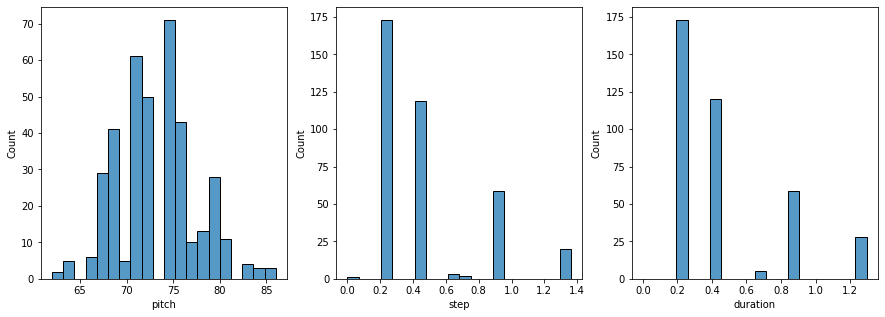

In [ ]:
plot_distributions(raw_notes)

## Create a MIDI file


In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Generated MIDI file.

In [ ]:
display_audio(example_pm)

## Training dataset


In [ ]:
num_files = 16
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 25909


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.609375  0.        0.95     ]
 [0.6171875 1.        0.95     ]
 [0.6171875 1.        0.95     ]
 [0.6328125 1.        0.95     ]
 [0.640625  1.        0.7125   ]
 [0.6328125 0.75      0.2375   ]
 [0.6328125 0.25      0.2375   ]
 [0.6171875 0.25      0.2375   ]
 [0.6171875 0.25      0.2375   ]
 [0.609375  0.25      0.2375   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=74.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.25>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.9000000000000004>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Train the model

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

404/404 [==============================] - 8s 4ms/step - loss: 4.9684 - duration_loss: 0.0620 - pitch_loss: 4.8495 - step_loss: 0.0570


{'duration_loss': 0.062000539153814316,
 'loss': 4.968447685241699,
 'pitch_loss': 4.849469184875488,
 'step_loss': 0.05697748810052872}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

404/404 [==============================] - 2s 4ms/step - loss: 0.3615 - duration_loss: 0.0620 - pitch_loss: 4.8495 - step_loss: 0.0570


{'duration_loss': 0.062000539153814316,
 'loss': 0.36145150661468506,
 'pitch_loss': 4.849469184875488,
 'step_loss': 0.05697748810052872}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
404/404 [==============================] - 4s 5ms/step - loss: 0.2459 - duration_loss: 0.0379 - pitch_loss: 3.8871 - step_loss: 0.0136
Epoch 2/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2275 - duration_loss: 0.0365 - pitch_loss: 3.7279 - step_loss: 0.0046
Epoch 3/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2248 - duration_loss: 0.0361 - pitch_loss: 3.7032 - step_loss: 0.0035
Epoch 4/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2293 - duration_loss: 0.0361 - pitch_loss: 3.7171 - step_loss: 0.0074
Epoch 5/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2234 - duration_loss: 0.0357 - pitch_loss: 3.6894 - step_loss: 0.0032
Epoch 6/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2224 - duration_loss: 0.0353 - pitch_loss: 3.6748 - step_loss: 0.0034
Epoch 7/50
404/404 [==============================] - 2s 5ms/step - loss: 0.2212 - duration_loss: 0.0351 - pitch_loss: 3.661

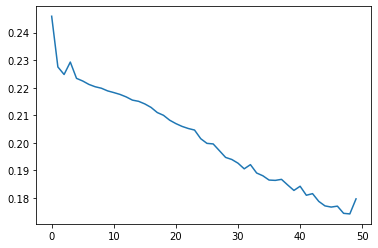

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.455059,0.673037,0.455059,1.128096
1,76,0.000000,0.143761,0.455059,0.598820
2,99,0.000000,0.129637,0.455059,0.584696
3,68,0.000000,0.106578,0.455059,0.561637
4,52,0.000000,0.094405,0.455059,0.549465
5,74,0.000000,0.091399,0.455059,0.546458
6,73,0.000000,0.094134,0.455059,0.549193
7,73,0.000000,0.095401,0.455059,0.550460
8,74,0.000000,0.097187,0.455059,0.552246
9,67,0.000000,0.099807,0.455059,0.554866


Generated MIDI file using RNN

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>